# **Breast-Cancer Tumour Classification**


In [54]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, RocCurveDisplay,
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

plt.style.use("default")             # keep plots clean for the report
RANDOM_STATE = 42                    # reproducibility


## **Task 1 – Data Exploration**

1. Investigate the distribution of the target variable (Malignant vs. Benign). 
2. Generate basic statistics (mean, median, standard deviation) for numerical features. 
3. Create initial visualizations (histograms, box plots) to spot outliers or skew. 
4. Calculate correlation coefficients (e.g., Pearson correlation) between features and the target. 
    - Identify any strongly correlated features that might be particularly predictive or 
potentially redundant. 

In [55]:
import pandas as pd

try:
    df = pd.read_csv('breast_cancer_dataset.csv')
    
except FileNotFoundError:
    print("Error: 'breast_cancer_dataset.csv' not found. Please ensure the file exists in the current directory or provide the correct path.")
    df = None
    
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


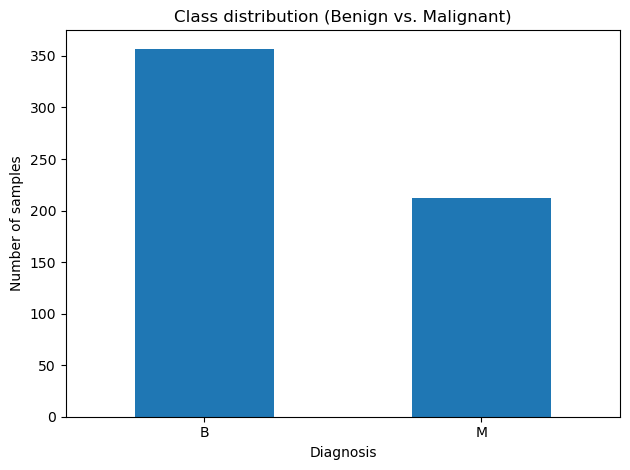

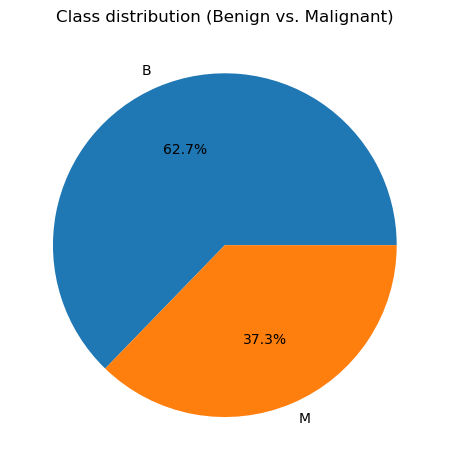

In [56]:
# Task: 1.1. Investigate the distribution of the target variable (Malignant vs. Benign). 

# Count benign (B) and malignant (M) samples
class_counts = df["diagnosis"].value_counts()   # returns a Series like: B 357, M 212

# ── BAR CHART (countplot equivalent) ──
plt.figure()
class_counts.plot(kind="bar")
plt.title("Class distribution (Benign vs. Malignant)")
plt.xlabel("Diagnosis")
plt.ylabel("Number of samples")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ── PIE CHART ──
plt.figure()
class_counts.plot(kind="pie", autopct="%1.1f%%")
plt.title("Class distribution (Benign vs. Malignant)")
plt.ylabel("")               # hide unnecessary y-label
plt.tight_layout()
plt.show()


``“The dataset contains 357 benign (63 %) and 212 malignant (37 %) cases.”``


Shape of the DataFrame: (569, 32)

Descriptive statistics (excerpt):
                            mean      std  std/mean
radius_mean               14.127    3.524     0.249
texture_mean              19.290    4.301     0.223
perimeter_mean            91.969   24.299     0.264
area_mean                654.889  351.914     0.537
smoothness_mean            0.096    0.014     0.146
compactness_mean           0.104    0.053     0.506
concavity_mean             0.089    0.080     0.898
concave points_mean        0.049    0.039     0.793
symmetry_mean              0.181    0.027     0.151
fractal_dimension_mean     0.063    0.007     0.112
radius_se                  0.405    0.277     0.684
texture_se                 1.217    0.552     0.453
perimeter_se               2.866    2.022     0.705
area_se                   40.337   45.491     1.128
smoothness_se              0.007    0.003     0.426
compactness_se             0.025    0.018     0.703
concavity_se               0.032    0.030     0

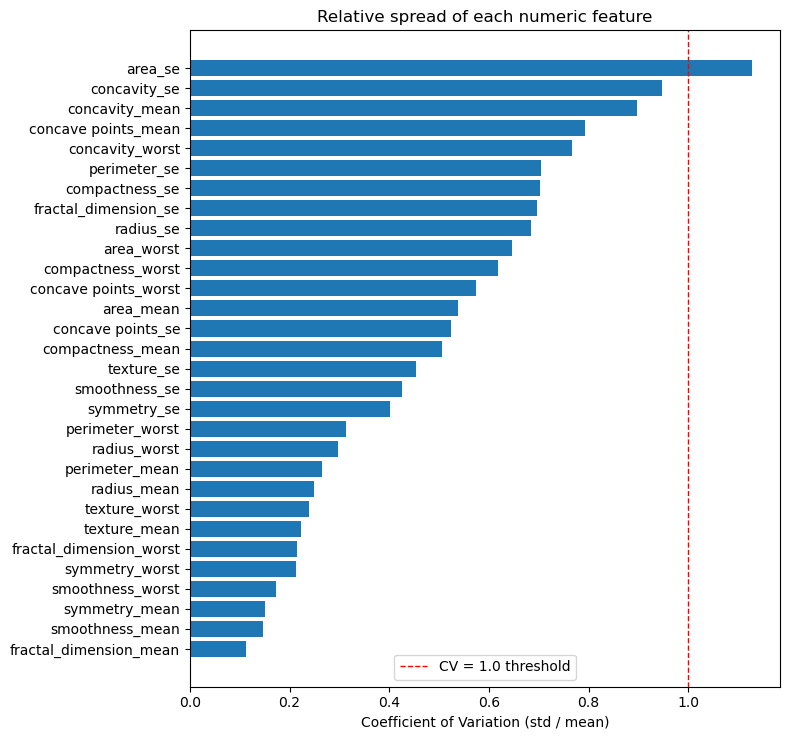

In [57]:
# ─────────────────────────────────────────
# Task 1.2 – Descriptive statistics & EDA
# ─────────────────────────────────────────

# 1. Check the shape of the DataFrame
print("Shape of the DataFrame:", df.shape)

# 3. DESCRIPTIVE STATISTICS ───────────────
#    Build a table with mean, std, and the spread-to-centre ratio.
desc = (
    df.select_dtypes("number")
      .drop(columns="id")          # keep id out of the stats
      .describe()
      .T
)

desc["std/mean"] = desc["std"] / desc["mean"]
print("\nDescriptive statistics (excerpt):")
print(desc[["mean", "std", "std/mean"]].round(3))   # show first few rows

# df.describe().T

# ───────────────────────────────────────────
# Plot the std/mean (coefficient of variation)
# ───────────────────────────────────────────
import matplotlib.pyplot as plt

# 1️⃣  Extract the CV column and sort descending
cv = (desc["std/mean"]
      .sort_values(ascending=True))   # lowest at bottom, highest at top

# 2️⃣  Draw a horizontal bar chart
plt.figure(figsize=(8, len(cv) * 0.25))  # auto-size by number of features
plt.barh(cv.index, cv.values)
plt.xlabel("Coefficient of Variation (std / mean)")
plt.title("Relative spread of each numeric feature")
plt.axvline(1.0, color="red", linestyle="--", linewidth=1,
            label="CV = 1.0 threshold")         # optional reference line
plt.legend()
plt.tight_layout()
plt.show()


In [58]:
# 7. OPTIONAL: LIST TOP std/mean RATIOS ───
print("\nHighest std/mean ratios (possible skew/outliers):")
print(desc["std/mean"].sort_values(ascending=False).head(8).round(2))


Highest std/mean ratios (possible skew/outliers):
area_se                 1.13
concavity_se            0.95
concavity_mean          0.90
concave points_mean     0.79
concavity_worst         0.77
perimeter_se            0.71
compactness_se          0.70
fractal_dimension_se    0.70
Name: std/mean, dtype: float64


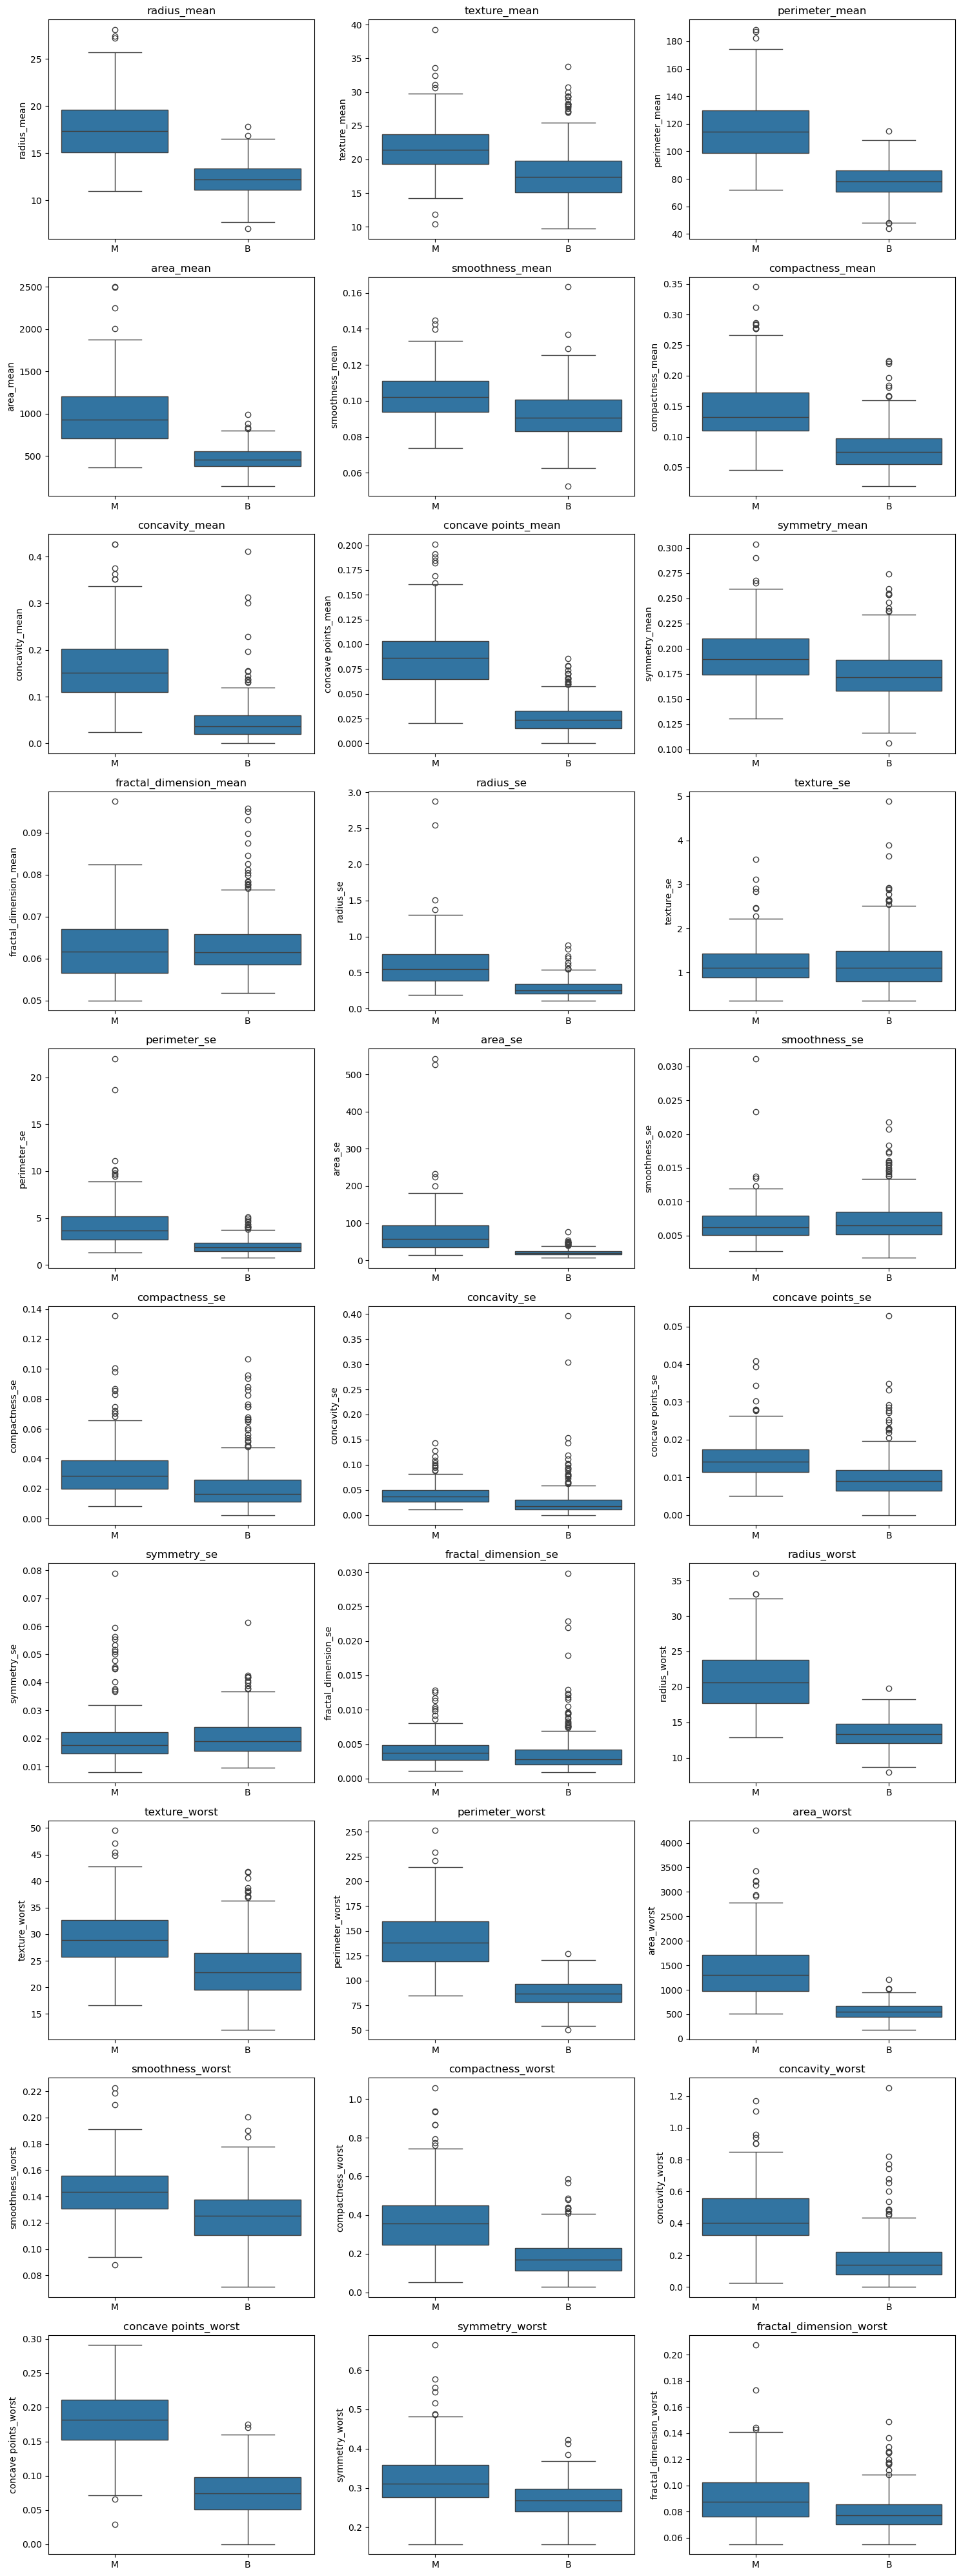

In [59]:
# 5. BOX-PLOTS FOR EVERY NUMERIC FEATURE ──
numeric_features = (
    df.drop(columns=["diagnosis", "id"])
      .select_dtypes("number")
      .columns
)
n_features = len(numeric_features)
ncols      = 3                           # three plots per row
nrows      = math.ceil(n_features / ncols)

plt.figure(figsize=(5 * ncols, 4 * nrows))
for idx, feature in enumerate(numeric_features, start=1):
    plt.subplot(nrows, ncols, idx)
    sns.boxplot(x="diagnosis", y=feature, data=df)
    plt.title(feature)
    plt.xlabel("")                       # save space
plt.tight_layout()
plt.show()



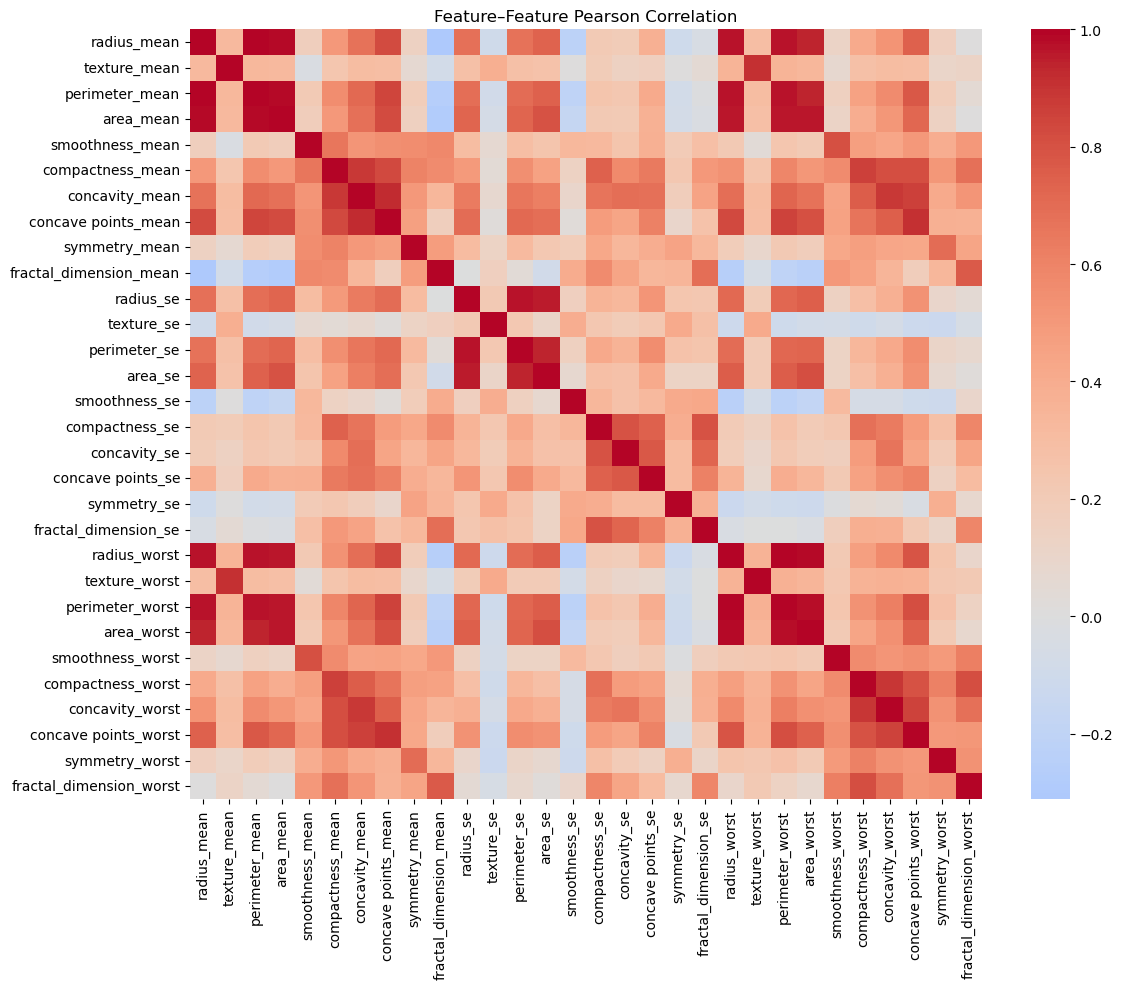

In [60]:
# 6. CORRELATION MATRIX ───────────────────
plt.figure(figsize=(12, 10))
corr = (
    df.drop(columns=["diagnosis", "id"])   # focus on predictors only
      .corr(method="pearson")
)
sns.heatmap(corr, cmap="coolwarm", center=0, fmt=".2f", annot=False)
plt.title("Feature–Feature Pearson Correlation")
plt.tight_layout()
plt.show()

In [61]:
# ---------------------------------------------------------
# list of highly-correlated pairs
# ---------------------------------------------------------
import itertools, numpy as np, pandas as pd, matplotlib.pyplot as plt

# 1. Encode the target (needed only if you also want feature-to-target r)
df["diagnosis_num"] = df["diagnosis"].map({"B": 0, "M": 1})

# 2. Keep only numeric predictors (drop id & encoded target for heat-map)
features = df.drop(columns=["id", "diagnosis", "diagnosis_num"])


# 5. List pairs with |r| > 0.85
high_pairs = []
for i, j in itertools.combinations(range(len(corr)), 2):
    r = corr.iat[i, j]
    if abs(r) > 0.85:
        high_pairs.append((corr.index[i], corr.columns[j], r))

high_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print(f"\nFound {len(high_pairs)} feature pairs with |r| > 0.85:\n")
for f1, f2, r in high_pairs:
    print(f"{f1:<25s}  ~  {f2:<25s}  r = {r:+.3f}")
    
    
# Correlation between the features and the target variables

df[features.columns.tolist() + ["diagnosis_num"]].corr()["diagnosis_num"].sort_values(ascending=False).head()


Found 29 feature pairs with |r| > 0.85:

radius_mean                ~  perimeter_mean             r = +0.998
radius_worst               ~  perimeter_worst            r = +0.994
radius_mean                ~  area_mean                  r = +0.987
perimeter_mean             ~  area_mean                  r = +0.987
radius_worst               ~  area_worst                 r = +0.984
perimeter_worst            ~  area_worst                 r = +0.978
radius_se                  ~  perimeter_se               r = +0.973
perimeter_mean             ~  perimeter_worst            r = +0.970
radius_mean                ~  radius_worst               r = +0.970
perimeter_mean             ~  radius_worst               r = +0.969
radius_mean                ~  perimeter_worst            r = +0.965
area_mean                  ~  radius_worst               r = +0.963
area_mean                  ~  area_worst                 r = +0.959
area_mean                  ~  perimeter_worst            r = +0.959
radius

diagnosis_num           1.000000
concave points_worst    0.793566
perimeter_worst         0.782914
concave points_mean     0.776614
radius_worst            0.776454
Name: diagnosis_num, dtype: float64

Observations:
1. Initial observations on data types, distributions, and potential outliers.
2. Observations on the relationship between the target and features based on the visualizations.
3. Observations on highly correlated features based on the correlation matrix.

In [62]:
# Identify potential outliers in numerical features
print("\nPotential Outliers:")
for col in features:
    print(f"Outliers in {col}:")
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(outliers[col])


Potential Outliers:
Outliers in radius_mean:
82     25.22
108    22.27
122    24.25
164    23.27
180    27.22
202    23.29
212    28.11
236    23.21
339    23.51
352    25.73
369    22.01
461    27.42
503    23.09
521    24.63
Name: radius_mean, dtype: float64
Outliers in texture_mean:
219    32.47
232    33.81
239    39.28
259    33.56
265    31.12
455    30.72
562    30.62
Name: texture_mean, dtype: float64
Outliers in perimeter_mean:
82     171.5
108    152.8
122    166.2
164    152.1
180    182.1
202    158.9
212    188.5
236    153.5
339    155.1
352    174.2
461    186.9
503    152.1
521    165.5
Name: perimeter_mean, dtype: float64
Outliers in area_mean:
23     1404.0
82     1878.0
108    1509.0
122    1761.0
164    1686.0
180    2250.0
202    1685.0
212    2499.0
236    1670.0
250    1364.0
265    1419.0
272    1491.0
339    1747.0
352    2010.0
368    1546.0
369    1482.0
372    1386.0
373    1335.0
393    1407.0
449    1384.0
461    2501.0
503    1682.0
521    1841.0
563    

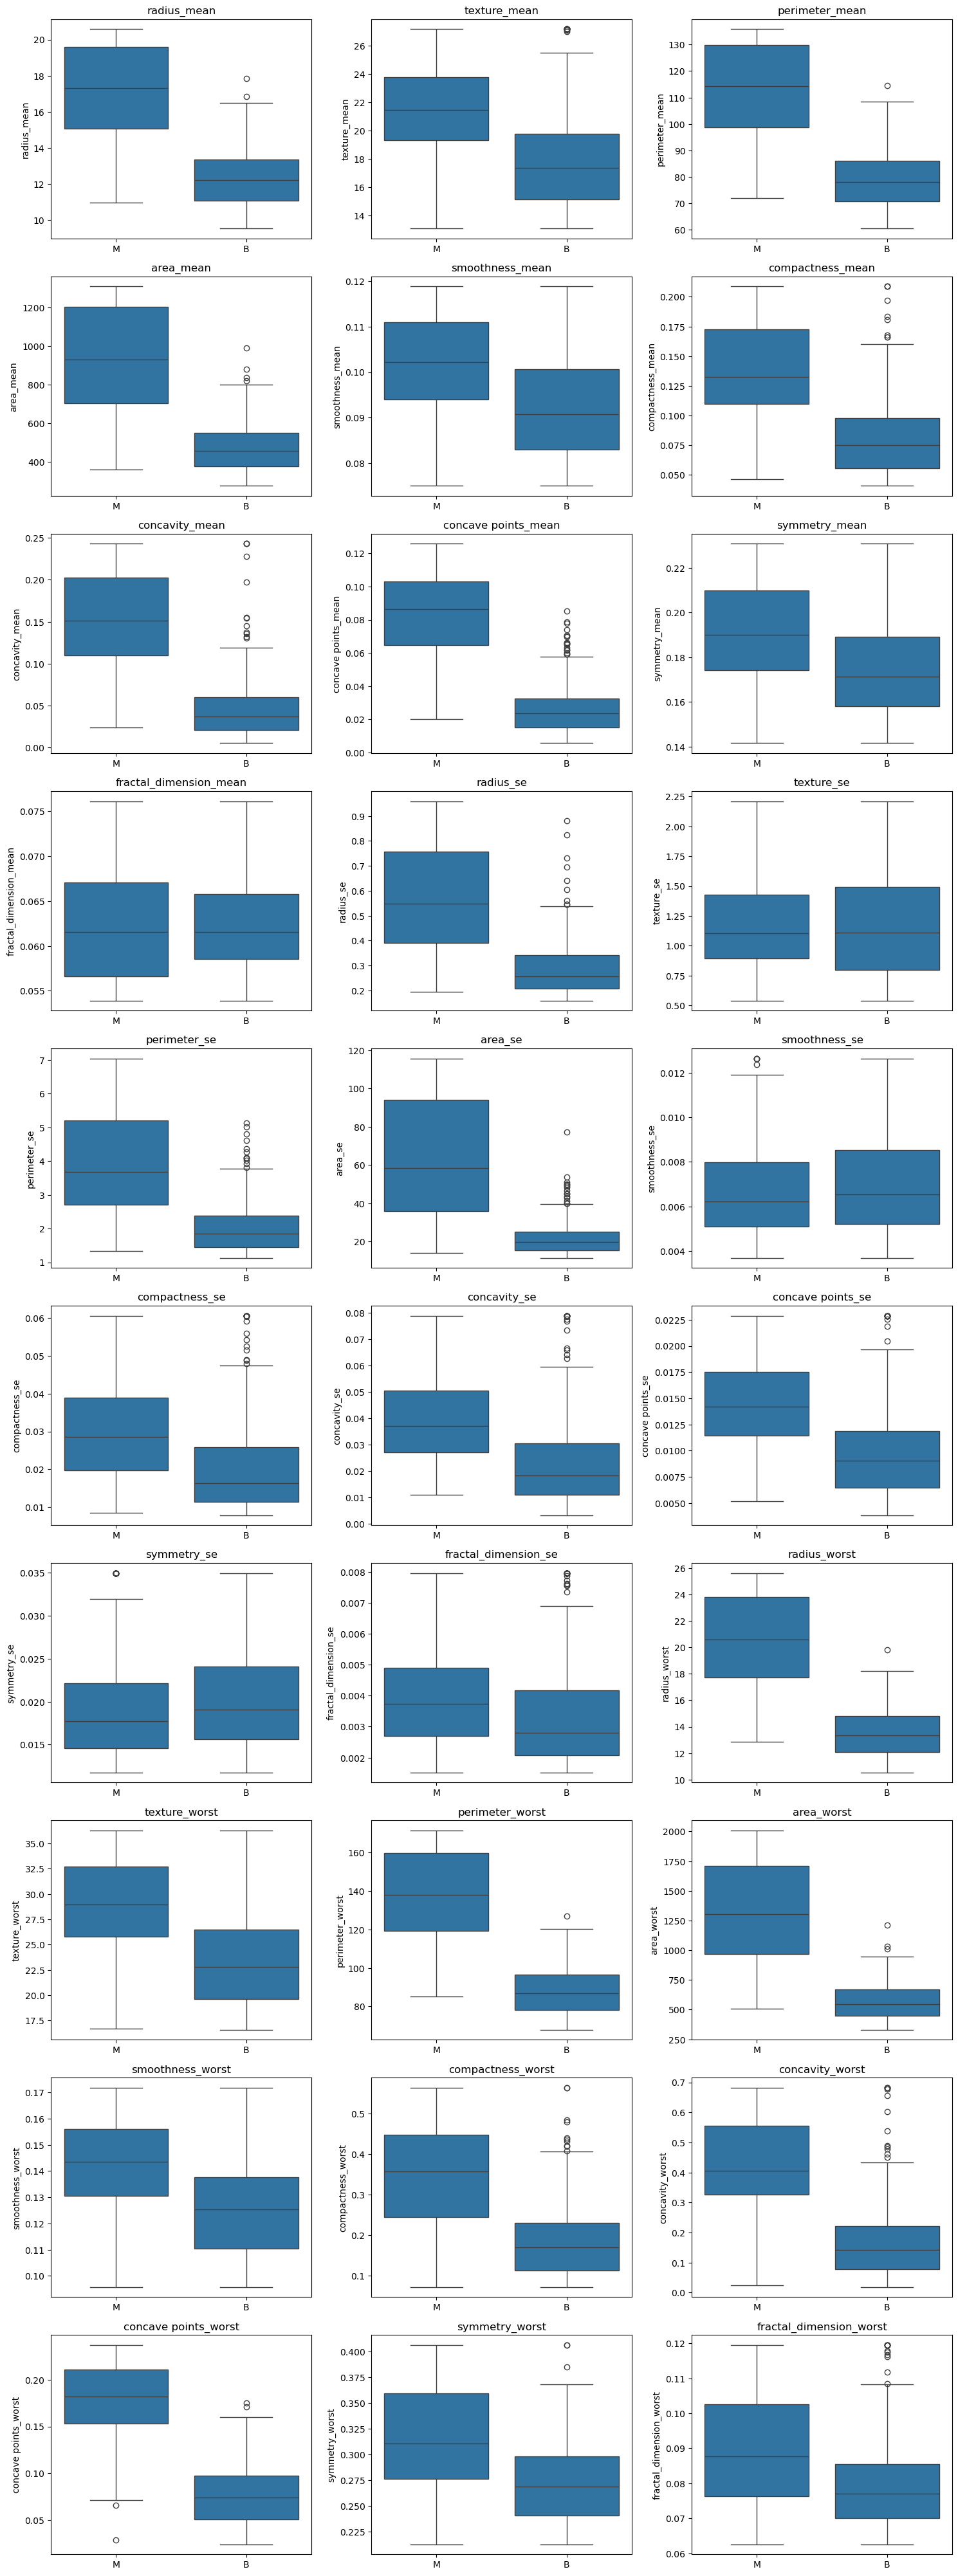

In [63]:
# Handling Outliers
for col in features:
    df[col] = df[col].clip(lower=df[col].quantile(0.05), upper=df[col].quantile(0.95))
    
df_cleaned = df.copy()


# Box plot to check the outlers again

n_features = len(features)
ncols      = 3                           # three plots per row
nrows      = math.ceil(n_features / ncols)

plt.figure(figsize=(5 * ncols, 4 * nrows))
for idx, feature in enumerate(features, start=1):
    plt.subplot(nrows, ncols, idx)
    sns.boxplot(x="diagnosis", y=feature, data=df_cleaned)
    plt.title(feature)
    plt.xlabel("")                       # save space
plt.tight_layout()
plt.show()


## **Task 2 – Data Preparation**
1. Assign the diagnosis column as the target variable. 
2. Identify any missing values. 
3. Discuss and implement an appropriate imputation strategy (drop, mean, median, etc.) if 
needed. 
4. Use a scaling approach (StandardScaler, MinMaxScaler) to ensure numerical features share 
a similar range. 

In [69]:
# 2.1 - Assign the diagnosis column as the target variable. 

# Drop columns that are *not* predictors
# 'diagnosis' is the label, not a feature
# 'id' is just an identifier
X = df_cleaned.drop(columns=["diagnosis", "id"])

#  Encode the label column into numbers
#  Malignant = 1   
#  Benign = 0
y = df_cleaned["diagnosis"].map({"M": 1, "B": 0})

## **Task 3 – Model Training**

1. Split data into training and testing sets and explain the rationale for the chosen split ratio. 
2. Choose multiple classification algorithms (e.g., Logistic Regression, Support Vector Machine, 
Decision Tree, Random Forest, K-Nearest Neighbors). 
3. Train each chosen model on the training set. 
4. Record the default hyperparameters used initially.

In [70]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [71]:
# Model training

# Subtask:
# Train a decision tree classifier on the prepared training data.

from sklearn.tree import DecisionTreeClassifier

# Initialize the DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=10)

# Train the model
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42)

## **Task 4 – Evaluation & Visualisation**
1. Evaluate each model on the test set using accuracy, precision, recall, F1-score, and AUC. 
2. Present results in a clear table or multiple plots (e.g., confusion matrix, ROC curve). 
3. Discuss which model performed best and why (based on metrics). 
4.  Select the top-performing model(s) for further fine-tuning (e.g., using GridSearchCV or 
RandomizedSearchCV). 
5. Compare pre- vs. post-tuning performance to show improvements.

In [72]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import make_scorer, f1_score, roc_auc_score, accuracy_score

# # Define the parameter grid
# param_grid = {
#     'max_depth': [3, 5, 7, 10],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': [None, 'sqrt', 'log2'],
#     'criterion': ['gini', 'entropy']
# }

# # Initialize GridSearchCV
# scoring = {'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score), 'accuracy': make_scorer(accuracy_score)}
# grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid, scoring=scoring, refit='roc_auc', cv=5, n_jobs=-1)

# # Fit GridSearchCV
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters and best score
# print("Best Hyperparameters:", grid_search.best_params_)
# print("Best Score (ROC AUC):", grid_search.best_score_)

# # Store the best estimator
# best_dt_model = grid_search.best_estimator_

In [73]:
# import numpy as np

# # Check for infinite values in X_test
# for col in X_test.columns:
#     if np.isinf(X_test[col]).any():
#         print(f"Column '{col}' contains infinite values.")
#         X_test[col] = X_test[col].replace([np.inf, -np.inf], np.nan)

# # Impute NaN values with the median of each column in X_test
# for col in X_test.select_dtypes(include=np.number).columns:
#     if X_test[col].isnull().any():
#         X_test[col] = X_test[col].fillna(X_test[col].median())

# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# import pandas as pd

# # Predict on the test set
# y_pred = best_dt_model.predict(X_test)
# y_prob = best_dt_model.predict_proba(X_test)[:, 1]

# # Calculate evaluation metrics
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_prob)

# # Create a summary table
# evaluation_metrics = pd.DataFrame({
#     'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC'],
#     'Value': [accuracy, precision, recall, f1, roc_auc]
# })

# # Display the summary table
# display(evaluation_metrics)

# # Interpretation of the results
# print("\nInterpretation:")
# print(f"The model achieved an accuracy of {accuracy:.4f}, indicating that it correctly classified {accuracy*100:.2f}% of the test instances.")
# print(f"The precision is {precision:.4f}, meaning that out of all the instances predicted as positive, {precision*100:.2f}% were actually positive.")
# print(f"The recall is {recall:.4f}, which means that the model correctly identified {recall*100:.2f}% of the actual positive instances.")
# print(f"The F1-score is {f1:.4f}, representing the harmonic mean of precision and recall.")
# print(f"The AUC-ROC score is {roc_auc:.4f}, which measures the model's ability to distinguish between classes.")

In [75]:
# Evaluate the model's accuracy on the test set
accuracy = dt_model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 100.00%


## **Task 5 – Conclusion & Future Work**

1. Summary of Findings 
   - Recap which model ultimately performed best. 
   - Highlight any key insights from the feature importance or metrics. 
   - Address data constraints (e.g., sample size, missing features) or any assumptions 
made. 
   - Discuss generalizability to other datasets or populations. 
2. Future Work 
   - Suggest additional techniques (e.g., more advanced models like neural networks) or 
feature engineering for improved results. 
   - Mention the potential for explainability in medical contexts.